In [1]:
import os

from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pprint

In [2]:
for data_name in ["mnist", "spam"]:
    data = io.loadmat("data/%s_data.mat" % data_name)
    print("\nloaded %s data!" % data_name)
    fields = "test_data", "training_data", "training_labels"
    for field in fields:
        print(field, data[field].shape)


loaded mnist data!
test_data (10000, 784)
training_data (60000, 784)
training_labels (60000, 1)

loaded spam data!
test_data (5857, 32)
training_data (5172, 32)
training_labels (5172, 1)


In [3]:
# Load all data and change them as float as needed.
mnist = io.loadmat("data/mnist_data.mat")
spam = io.loadmat("data/spam_data.mat")
mnist_X, mnist_y = mnist['training_data'].astype(float), mnist['training_labels']
mnist_test_X = mnist['test_data'].astype(float)
spam_X, spam_y = spam['training_data'].astype(float), spam['training_labels']
spam_test_X = spam['test_data'].astype(float)

In [4]:
# Contrast normalization to the training set cn_mnist_X
cn_mnist_X = []
for i in range(len(mnist_X)):
    image = mnist_X[i]/(np.linalg.norm(mnist_X[i])+1e-15)
    cn_mnist_X.append(image)
    
cn_mnist_X = np.array(cn_mnist_X)
cn_mnist_X.shape

(60000, 784)

In [5]:
# Contrast normalization to the testing set as well.
cn_mnist_test_X = []
for i in range(len(mnist_test_X)):
    image = mnist_test_X[i]/(np.linalg.norm(mnist_test_X[i])+1e-15)
    cn_mnist_test_X.append(image)
    
cn_mnist_test_X = np.array(cn_mnist_test_X)
cn_mnist_test_X.shape

(10000, 784)

In [6]:
# Seperate mnist digits into different folders.
number = len(mnist_y)
separated_mnist_X = [[] for i in range(10)]

for i in range(number):
    image = cn_mnist_X[i]
    separated_mnist_X[mnist_y[i][0]].append(image)
    
separated_mnist_X = np.array(separated_mnist_X)
separated_mnist_X.shape

(10,)

In [7]:
def FitGaussian(data):
    mu = np.mean(data, axis=0)
    sigma = np.cov(data.T)
    return mu, sigma

In [8]:
Gaussian_digit = {}
for i in range(10):
    digit_array = np.array(separated_mnist_X[i])
    Gaussian_digit['mu%d'%i], Gaussian_digit['sigma%d'%i] = \
        FitGaussian(digit_array)

<font size=3.3> I stored my mean and cavariance matrices in a dictionary called Gaussian_digit

<font size='3.3'>**2.**

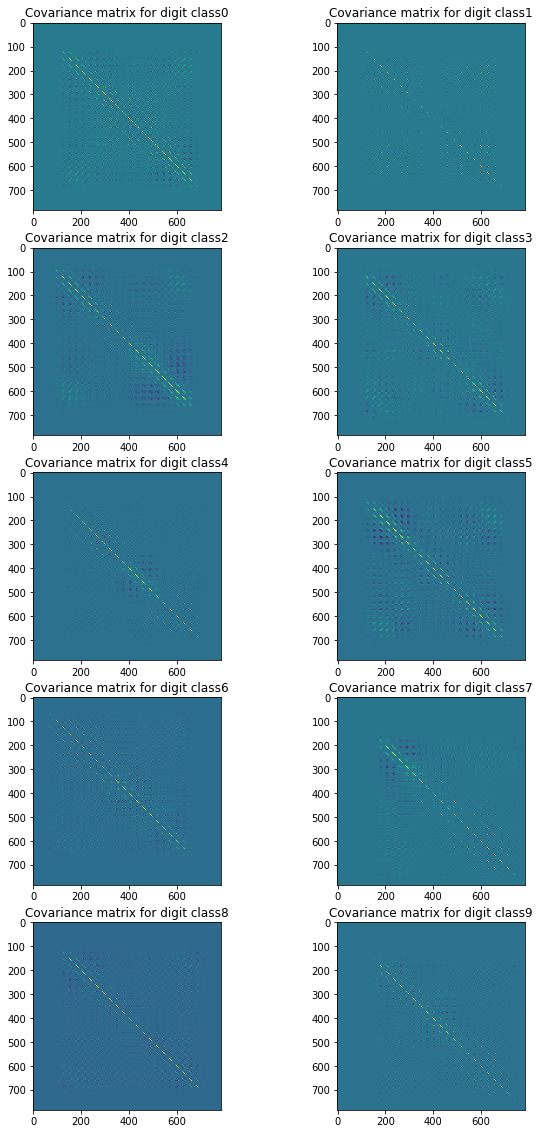

In [9]:
fig, axes = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    for j in range(2):
        axes[i,j].imshow(Gaussian_digit['sigma%d'% (2*i + j)])
        axes[i, j].set_title('Covariance matrix for digit class' + str(2*i + j))

<font size=3.3>**SOLUTION**<br>The diagonal terms are highlighted, meaning it's having a larger value than the off-diagonal entrices. So they are independent since the covariance are low and variance are high.

<font size=3.3>**(3)**<br>
**(a) LDA** <br>
I use np.linalg.solve to get the inverse of the covariance matrix.

In [8]:
# Utils from HW1. Set seed to 15 for data reproduction.
random = np.random.RandomState(66)
def split(data, labels, val_size):
    num_items = len(data)
    assert num_items == len(labels)
    assert val_size >= 0
    if val_size < 1.0:
        val_size = int(num_items * val_size)
    train_size = num_items - val_size
    idx = random.permutation(num_items)
    data_train = data[idx][:train_size]
    label_train = labels[idx][:train_size]
    data_val = data[idx][train_size:]
    label_val = labels[idx][train_size:]
    return data_train, data_val, label_train, label_val

In [11]:
class LDA:
    def __init__(self):
        self.mu = None
        self.sigma = None
        self.Pi = None
    
    def fit(self, X, y):
        
        N, labels = len(y), np.unique(y)
        d = X.shape[1]
        C = len(labels)
        mu = np.zeros((C, d))
        Pi = np.zeros(C)
        sigma = np.zeros((d, d))
        for i, label in enumerate(labels):
            X_i = []
            for index, result in enumerate(y):
                if result == label:
                    X_i.append(X[index])
            X_i = np.array(X_i)
            #print(len(X_i))
            Pi[i] = len(X_i) / N
            mu[i, :] = np.mean(X_i, axis=0)
            sigma += np.cov(X_i.T)*X_i.shape[0]
        sigma /= N
        self.mu = mu
        self.sigma = sigma
        self.Pi = Pi
    
    def predict(self, X):
        #sigma_inv = np.linalg.pinv(self.sigma)
        d = len(self.sigma)
        self.sigma += 1e-15*np.array(np.eye(d))
        L1 = self.mu.dot(np.linalg.solve(self.sigma, X.T)).T
        L2 = 1/2*np.diag(self.mu.dot\
                         (np.linalg.solve(self.sigma, self.mu.T)))
        L = L1 - L2 - np.log(self.Pi)
        pred = np.argmax(L.T, axis=0)
        #print(len(pred))
        return pred
    
    def accuracy(self, X, y):
        N = len(y)
        correct = 0
        pred = self.predict(X)
        for i in range(N):
            if pred[i] == y[i]:
                correct += 1
        return correct/N, pred

In [15]:
# Seperate the data into train and validation sets
mnist_train_X, mnist_val_X, mnist_train_y, mnist_val_y = \
                                split(cn_mnist_X, mnist_y, 10000)

print(mnist_train_X.shape, mnist_val_X.shape)

(50000, 784) (10000, 784)


In [13]:
training_size = np.array([100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000])
accuracy_list = np.zeros(len(training_size))

for i, N in enumerate(training_size):
    clf = LDA()
    clf.fit(mnist_train_X[:N,:], mnist_train_y[:N])
    accuracy_list[i], _ = clf.accuracy(mnist_val_X, mnist_val_y)

accuracy_list

array([0.6699, 0.6789, 0.3454, 0.685 , 0.7901, 0.8474, 0.8607, 0.8697,
       0.8723])

<font size=3.3> I choose the xscale to be log so we can have a more clear sense of the trending.

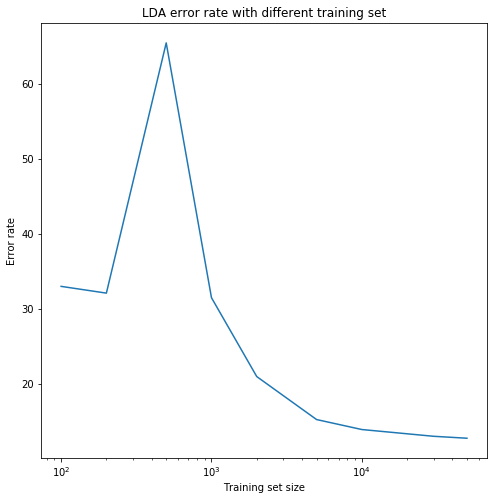

In [16]:
plt.figure(figsize=(8, 8))
plt.plot(training_size, (1-accuracy_list) * 100)
plt.xscale('log')
plt.title('LDA error rate with different training set')
plt.xlabel('Training set size')
plt.ylabel('Error rate')
plt
plt.show()

<font size=3.3> **(b)QDA** <br>
For QDA, I find that using scipy.stats.multivariate_normal is much faster than writing the equation in np.linalg.solve and np.det. 

In [17]:
from scipy.stats import multivariate_normal

class QDA:
    def __init__(self, a):
        self.mu = None
        self.sigma = None
        self.Pi = None
        self.a = a
    
    def fit(self, X, y):
        N, labels = len(y), np.unique(y)
        #print(labels)
        d = X.shape[1]
        C = len(labels)
        sigma = [np.zeros([d, d]) for i in range(N)]
        mu = np.zeros([C, d])
        Pi = np.zeros([C])
        for i, label in enumerate(labels):
            # Get each classes' statistics
            X_i = []
            for index, result in enumerate(y):
                if result == label:
                    X_i.append(X[index])
            X_i = np.array(X_i)
            #print(len(X_i))
            Pi[i] = len(X_i) / N
            mu[i, :] = np.mean(X_i, axis=0)
            sigma[i] = np.cov(X_i.T) + self.a*np.eye(d)
        self.mu = mu
        self.sigma = sigma
        self.Pi = Pi

        
    def predict(self, X):
        C = len(self.Pi)
        L = np.zeros((C, len(X)))
        mu = self.mu
        sigma = self.sigma
        #print(len(sigma))
        Pi = self.Pi
        for i in range(C):
            #print('start')
            L[i,:] = multivariate_normal.logpdf(X, mean=mu[i], cov=sigma[i])
            #print('finish')
            L[i,:] += np.log(Pi[i])
        pred = np.argmax(L, axis=0)
        return pred
    
    def accuracy(self, X, y):
        N = len(y)
        print('start predicting')
        correct = 0
        pred = self.predict(X)
        print('finish predicting')
        #print('finish %d' %N)
        for i in range(N):
            if pred[i] == y[i]:
                correct += 1
        #print('accuracy', correct/N)
        return correct/N, pred


In [18]:
training_size = np.array([100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000])
accuracy_list = np.zeros(len(training_size))

small = np.array(training_size)
for i, N in enumerate(small):
    clf = QDA(1e-8)
    clf.fit(mnist_train_X[:N,:], mnist_train_y[:N])
    accuracy_list[i], _ = clf.accuracy(mnist_val_X, mnist_val_y)

accuracy_list

start predicting
finish predicting
start predicting
finish predicting
start predicting
finish predicting
start predicting
finish predicting
start predicting
finish predicting
start predicting
finish predicting
start predicting
finish predicting
start predicting
finish predicting
start predicting
finish predicting


array([0.7622, 0.8464, 0.8551, 0.9003, 0.8503, 0.7521, 0.8189, 0.8153,
       0.8042])

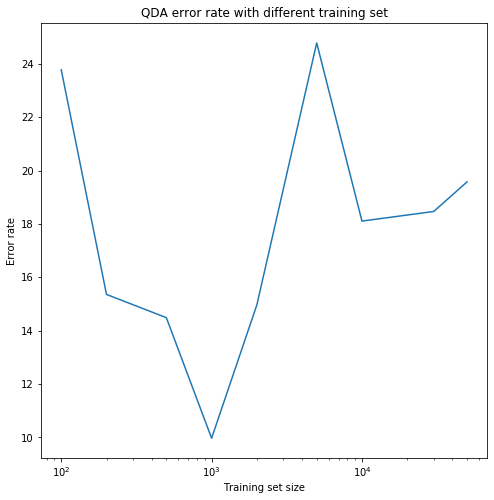

In [19]:
plt.figure(figsize=(8, 8))
plt.plot(training_size, (1-accuracy_list) * 100)
plt.xscale('log')
plt.title('QDA error rate with different training set')
plt.xlabel('Training set size')
plt.ylabel('Error rate')
plt
plt.show()

<font size=3.3>**3.(C) SOLUTION**<br>QDA works better than LDA when the training set is small, but eventaully gets overfitting the data. This happens because the covariance matrices, from the ten graph we plot, are actually not too much different. By assuming they have different covariance matrices and introducing too many parameters, QDA tends to overfit.

<font size=3.3>**3.(d) Kaggle for MNIST**

In [6]:
# Helper function to safe the kaggle data.
def results_to_csv(y_test, name):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv(name + '.csv', index_label='Id')

In [21]:
#mnist_train_X, mnist_val_X, mnist_train_y, mnist_val_y, cn_mnist_test_X

In [22]:
mnist_clf = LDA()
mnist_clf.fit(mnist_train_X, mnist_train_y)
train_accuracy, train_prev = mnist_clf.accuracy(mnist_train_X, mnist_train_y)
val_accuracy, val_prev = mnist_clf.accuracy(mnist_val_X, mnist_val_y)
print(train_accuracy, val_accuracy)

0.88148 0.8723


In [23]:
q_mnist_clf = QDA(1e-8)
q_mnist_clf.fit(mnist_train_X, mnist_train_y)
train_accuracy, train_prev = q_mnist_clf.accuracy(mnist_train_X, mnist_train_y)
val_accuracy, val_prev = q_mnist_clf.accuracy(mnist_val_X, mnist_val_y)
print(train_accuracy, val_accuracy)

start predicting
finish predicting
start predicting
finish predicting
0.84282 0.8042


<font size=3.3> We see again that QDA overfit the data. We choose the LDA's result as our baseline for Kaggle competition.

In [141]:
#mnist_submit = mnist_clf.predict(cn_mnist_test_X)
#results_to_csv(mnist_submit, 'mnist_submit1')

In [150]:
# Training for LDA.
training_size = np.array([100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000])
val_acc_list = np.zeros(len(training_size))
val_pred_list = []

for i, N in enumerate(training_size):
    clf = LDA()
    clf.fit(mnist_train_X[:N], mnist_train_y[:N])
    val_acc_list[i], val_pred = clf.accuracy(mnist_val_X, mnist_val_y)
    val_pred_list.append(val_pred)

print(val_acc_list)
print(len(val_pred_list),len(val_pred_list[0]))

[0.88272 0.88272 0.88272 0.88272 0.88272 0.88272 0.88272 0.88272 0.88272] [0.6625 0.6557 0.331  0.6859 0.782  0.8397 0.8575 0.8633 0.8677]
9 10000


In [245]:
# Training for QDA
training_size = np.array([100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000])
q_val_acc_list = np.zeros(len(training_size))
q_val_pred_list = []

for i, N in enumerate(training_size):
    clf = QDA(1e-8)
    clf.fit(mnist_train_X[:N], mnist_train_y[:N])
    q_val_acc_list[i], val_pred = clf.accuracy(mnist_val_X, mnist_val_y)
    q_val_pred_list.append(val_pred)

print(q_val_acc_list)
print(len(q_val_pred_list),len(q_val_pred_list[0]))

accuracy: 0.7298
accuracy: 0.8401
accuracy: 0.8957
accuracy: 0.9085
accuracy: 0.8669
accuracy: 0.7222
accuracy: 0.8193
accuracy: 0.8112
accuracy: 0.7975
[0.7298 0.8401 0.8957 0.9085 0.8669 0.7222 0.8193 0.8112 0.7975]
9 10000


In [220]:
def compare(prediction, labels, N=10):
    digit_errors = np.zeros((N))
    prediction = prediction.reshape(len(prediction),1)
    for i in range(N):
        same = (labels == i)
        total_digit = sum(same)
        #print(total_digit)
        correct_digit = sum(prediction[same] == labels[same])
        error_rate = 1 - (correct_digit/total_digit)
        digit_errors[i] = error_rate
    return digit_errors

In [254]:
round_0 = compare(val_pred_list[0], np.array(mnist_val_y)).reshape(10,1)
round_1 = compare(val_pred_list[1], np.array(mnist_val_y)).reshape(10,1)
round_2 = compare(val_pred_list[2], np.array(mnist_val_y)).reshape(10,1)
round_3 = compare(val_pred_list[3], np.array(mnist_val_y)).reshape(10,1)
round_4 = compare(val_pred_list[4], np.array(mnist_val_y)).reshape(10,1)
round_5 = compare(val_pred_list[5], np.array(mnist_val_y)).reshape(10,1)
round_6 = compare(val_pred_list[6], np.array(mnist_val_y)).reshape(10,1)
round_7 = compare(val_pred_list[7], np.array(mnist_val_y)).reshape(10,1)
round_8 = compare(val_pred_list[8], np.array(mnist_val_y)).reshape(10,1)

In [246]:
q_0 = compare(q_val_pred_list[0], np.array(mnist_val_y)).reshape(10,1)
q_1 = compare(q_val_pred_list[1], np.array(mnist_val_y)).reshape(10,1)
q_2 = compare(q_val_pred_list[2], np.array(mnist_val_y)).reshape(10,1)
q_3 = compare(q_val_pred_list[3], np.array(mnist_val_y)).reshape(10,1)
q_4 = compare(q_val_pred_list[4], np.array(mnist_val_y)).reshape(10,1)
q_5 = compare(q_val_pred_list[5], np.array(mnist_val_y)).reshape(10,1)
q_6 = compare(q_val_pred_list[6], np.array(mnist_val_y)).reshape(10,1)
q_7 = compare(q_val_pred_list[7], np.array(mnist_val_y)).reshape(10,1)
q_8 = compare(q_val_pred_list[8], np.array(mnist_val_y)).reshape(10,1)

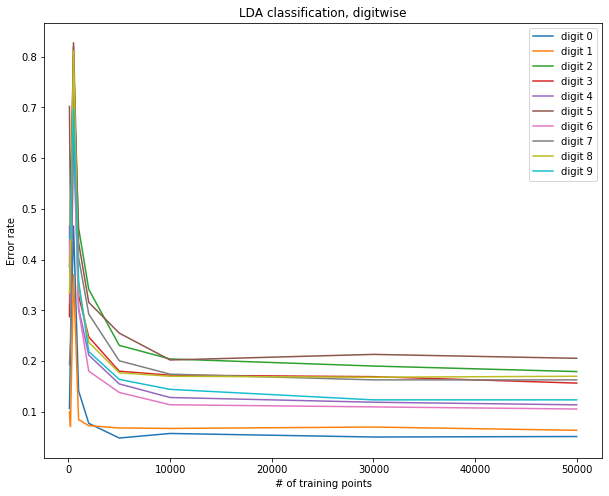

In [256]:
to_plot = np.concatenate((round_0,round_1,round_2,round_3,round_4,
                          round_5,round_6,round_7,round_8), axis=1)
plt.figure(figsize=(10,8))
for i in range(10):
    plt.plot(training_size, to_plot[i], label='digit '+ str(i))
    plt.legend()
    plt.title('LDA classification, digitwise')
    plt.xlabel('# of training points')
    plt.ylabel('Error rate')


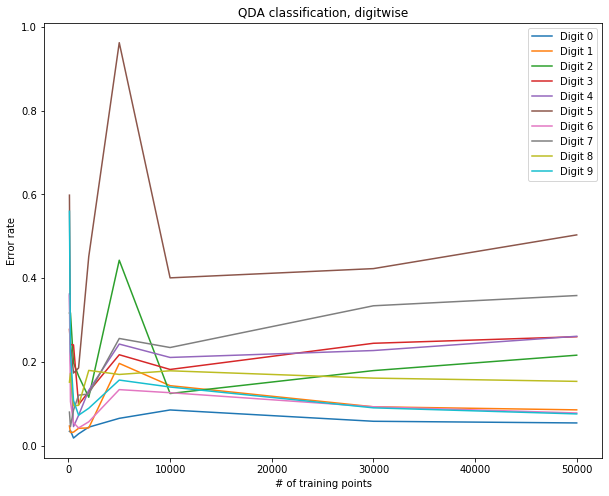

In [257]:
to_plot = np.concatenate((q_0,q_1,q_2,q_3,q_4,
                          q_5,q_6,q_7,q_8), axis=1)

plt.figure(figsize=(10,8))
for i in range(10):
    
    plt.plot(training_size, to_plot[i], label='Digit '+ str(i))
    plt.legend()
    plt.title('QDA classification, digitwise')
    plt.xlabel('# of training points')
    plt.ylabel('Error rate')
    

<font size=3.3> From both graph above, we can see that digits like 0 and 1 are pretty easy to train, hence having a small error rate at the end of the training. Digit 6 and 7 both have high error rate. The reason behind this might be 6 and 7 are easily being confused with other digits.

<font size=3.3>For the Kaggle competetion below, I used HOG to add more features to the design matrix.

In [7]:
from skimage.feature import hog

def hog_dataset(dataset):
    list_hog_fd = []
    for sample in dataset:
        #print(sample.shape)
        fd = hog(sample.reshape((28, 28)), orientations=8,
                 pixels_per_cell=(4, 4), cells_per_block=(1, 1), 
                 visualise=False)
        list_hog_fd.append(fd)
    return np.array(list_hog_fd, 'float64')

In [8]:
print(len(cn_mnist_X), len(mnist_y))

60000 60000


In [9]:
hog_train_X = hog_dataset(cn_mnist_X)
#hog_val_X = hog_dataset(mnist_val_X)
hog_test_X = hog_dataset(cn_mnist_test_X)

/Users/wesley/anaconda3/lib/python3.7/site-packages/skimage/feature/_hog.py:239: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


In [10]:
std_train_X= \
np.array([np.std(cn_mnist_X, axis=1)]).T
std_test_X = np.array([np.std(cn_mnist_test_X, axis=1)]).T

In [11]:
print(cn_mnist_X.shape, hog_train_X.shape, std_train_X.shape)

(60000, 784) (60000, 392) (60000, 1)


In [12]:
print(cn_mnist_test_X.shape, hog_test_X.shape, std_test_X.shape)

(10000, 784) (10000, 392) (10000, 1)


In [14]:
final_training = np.concatenate(
    (cn_mnist_X, hog_train_X, std_train_X), axis=1)
#final_val = np.concatenate((mnist_val_X, hog_val_X, std_val_X), axis=1)
print(final_training.shape)

(60000, 1177)


In [15]:
final_test = np.concatenate(
    (cn_mnist_test_X, hog_test_X, std_test_X), axis=1)

In [16]:
final_test.shape

(10000, 1177)

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

clf = QDA()
param_grid = {"reg_param" :[0.1, 0.5, 1, 2, 5, 10, 15]}

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

gs = gs.fit(final_training, mnist_y)
print(gs.best_score_)
print(gs.best_params_)

/Users/wesley/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wesley/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.9334
{'reg_param': 0.1}


In [19]:
clf = QDA()
param_grid = {"reg_param" :[0.01, 0.05, 0.1]}

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

gs = gs.fit(final_training, mnist_y)
print(gs.best_score_)
print(gs.best_params_)

/Users/wesley/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wesley/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.95295
{'reg_param': 0.01}


In [21]:
clf = QDA()
param_grid = {"reg_param" :[0.001, 0.01]}

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

gs = gs.fit(final_training, mnist_y)
print(gs.best_score_)
print(gs.best_params_)

/Users/wesley/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wesley/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.95295
{'reg_param': 0.01}


In [22]:
m_clf = QDA(reg_param=0.01)
m_clf.fit(final_training, mnist_y)
mnist_submit = m_clf.predict(final_test)
results_to_csv(mnist_submit, 'mnist_HOG_new')

/Users/wesley/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/wesley/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [32]:
m_clf = LDA()
m_clf.fit(final_training, mnist_train_y)
acc = m_clf.accuracy(final_val, mnist_val_y)
acc

(0.9424, array([9, 2, 7, ..., 1, 2, 8]))

In [33]:
 m_clf.accuracy(final_training, mnist_train_y)

(0.94894, array([7, 0, 9, ..., 8, 1, 7]))

In [34]:
mnist_submit = m_clf.predict(final_test)
results_to_csv(mnist_submit, 'mnist_HOG')

<font size=3.3>**4. Kaggle on SPAM**<br> For SPAM, I use the Bag of Word and use the max 1200 variance word to train the model. I use sklearn package's CountVectorizer function with minimum word length being 4.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
import glob

sf = glob.glob('data/spam/'  + '*.txt')
hf = glob.glob('data/ham/' + '*.txt')
tf = ['data/test/'  + str(x) + '.txt' for x in range(5857)]

In [7]:
all_train, all_test = [], []

for file in sf + hf:
    with open(file, "r", encoding='utf-8', errors='ignore') as f:
        all_train.append(f.read())

for file in tf:
    with open(file, "r", encoding='utf-8', errors='ignore') as f:
        all_test.append(f.read())

In [8]:
# Contrast Normalization Helper funtion.
def cn(X):
    norm_X = np.zeros(X.shape)
    for i in range(X.shape[0]):
        norm_X[i, :] = X[i, :]/(np.linalg.norm(X[i, :])+1e-12)
    return norm_X

In [9]:
vectorizer = CountVectorizer(min_df=4)
raw_training_X = vectorizer.fit_transform(all_train)
raw_test_X = vectorizer.transform(all_test)
# Normalization.
training_X, test_X = cn(raw_training_X.toarray()), cn(raw_test_X.toarray())
training_y = np.concatenate((np.ones(len(sf)), np.zeros(len(hf))))

In [10]:
std = np.std(training_X, axis=0)
word_index = std.argsort()[-2000:] # Tried out 600, 1000 and 1200.
final_training_X = training_X[:, word_index]
final_training_y = training_y
final_test_X = test_X[:, word_index]

In [40]:
clf = LDA()
clf.fit(final_training_X, final_training_y)
clf.accuracy(final_training_X, final_training_y)

(0.9924593967517401, array([1, 1, 1, ..., 0, 0, 0]))

In [41]:
spam_submit = clf.predict(final_test_X)
results_to_csv(spam_submit, 'SPAM')

In [12]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200)
clf.fit(final_training_X, final_training_y)
clf.score(final_training_X, final_training_y)

0.9998066511987626

In [15]:
spam_submit = clf.predict(final_test_X)
results_to_csv(spam_submit, 'SPAM')

In [20]:
final_training_X.shape

(5172, 2000)